In [6]:
import pandas as pd
import geopandas as gpd
import requests
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from io import StringIO
from pyfonts import load_google_font
from highlight_text import ax_text

#load the online GDP table
url = 'https://www.macrotrends.net/global-metrics/countries/ranking/gdp-gross-domestic-product'
headers = {"User-Agent": "Mozilla/5.0"}
html = requests.get(url, headers = headers).text

gdp = pd.read_html(StringIO(html))
df = gdp[0]
df.head()

,Country Name,2023,2022,2021,2020,2019
0,United States,"$27,360,935,000,000","$25,744,108,000,000","$23,594,031,000,000","$21,322,950,000,000","$21,521,395,000,000"
1,China,"$17,794,781,986,105","$17,881,783,387,001","$17,820,459,508,852","$14,687,744,162,801","$14,279,968,506,272"
2,Germany,"$4,456,081,016,706","$4,082,469,490,798","$4,278,503,934,690","$3,887,727,161,914","$3,889,177,589,255"
3,Japan,"$4,212,945,159,781","$4,256,410,760,724","$5,034,620,784,585","$5,055,587,093,502","$5,117,993,853,017"
4,India,"$3,549,918,918,778","$3,353,470,496,886","$3,167,270,623,261","$2,674,851,578,587","$2,835,606,256,559"


### Cleaning and sorting data:

In [7]:
# Clean values by removing all '$' sign and all commas, so GDP amounts can be converted to type 'int'
for column in df.columns[1:]:
    df[column] = df[column].str.replace('$','').str.replace(',','').astype('int')

# How many countries have missing values (GDP value == 0)?
print(f"{df.loc[df['2023'] == 0, '2023'].count()} countries missing GDP values")

# Who are the countries with 0 as GDP value in 2023? 
missing_countries = df.loc[df['2023'] == 0, 'Country Name'].values
missing_countries

25 countries missing GDP values


array(['Aruba', 'Afghanistan', 'American Samoa', 'Bermuda', 'Bhutan',
       'Channel Islands', 'Cuba', 'Curacao', 'Cayman Islands',
       'Faroe Islands', 'Greenland', 'Guam', 'Isle Of Man', 'Lebanon',
       'Liechtenstein', 'St. Martin (French Part)', 'Monaco',
       'Northern Mariana Islands', 'New Caledonia', 'French Polynesia',
       'Qatar', 'San Marino', 'Syrian Arab Republic', 'Tonga',
       'Virgin Islands (U.S.)'], dtype=object)

In [8]:
# Fill missing countries values from another dataset:

# (a) Create a dataframe object
df2 = pd.read_csv('API_NY.GDP.MKTP.CD_DS2_en_csv_v2_122379.csv', header = 2)

# (b) keep only countries that have a 2023 GDP value and are also in the missing countries list
df2 = (df2.loc[
 (df2['Country Name'].isin(missing_countries))
 &
 (df2['2023'].notna())
 , ['Country Name','2023']])

# Convert these values to integers
df2['2023'] = df2['2023'].astype('int')

new_coutnry_vals = df2['Country Name']

In [9]:
# Using the CSV file, how many missing countries was I able to find 2023 values?
len(df2)

16

In [10]:
# Fill in these values in the original df:

# (a) Create a mapping from df2
mapping_2023 = dict(zip(df2['Country Name'], df2['2023']))

# (b) Update df's 2023 column based on the mapping
df.loc[df['Country Name'].isin(new_coutnry_vals), '2023'] = (
    df.loc[df['Country Name'].isin(new_coutnry_vals), 'Country Name']
      .map(mapping_2023))

# Who are the countries we still have 0 as the GDP value in 2023? 
missing_countries = df.loc[df['2023'] == 0, 'Country Name'].values
missing_countries

array(['American Samoa', 'Cuba', 'Guam', 'Isle Of Man',
       'St. Martin (French Part)', 'Northern Mariana Islands',
       'New Caledonia', 'San Marino', 'Virgin Islands (U.S.)'],
      dtype=object)

In [11]:
# Fill in countries that still don't have value for 2023 with their 2022 GDP value
df.loc[(df['2023'] == 0) & (df['2022'] > 0), '2023'] = df.loc[(df['2023'] == 0) & (df['2022'] > 0), '2022']

# Fill in countries that still don't have value for 2023 with their 2021 GDP value if 2022 value is missing
df.loc[(df['2023'] == 0) & (df['2021'] > 0), '2023'] = df.loc[(df['2023'] == 0) & (df['2021'] > 0), '2021']

# Fill in countries that still don't have value for 2023 with their 2020 GDP value if 2021 value is missing
df.loc[(df['2023'] == 0) & (df['2020'] > 0), '2023'] = df.loc[(df['2023'] == 0) & (df['2020'] > 0), '2020']

# Double check no more countries in the df have 0 for their 2023 value
missing_countries = df.loc[df['2023'] == 0, 'Country Name'].values
len(missing_countries)

0

In [12]:
# Double check this is reflected in the dataframe:
df['2023'].isna().sum()

np.int64(0)

In [13]:
elon_worth = {2022: 219000000000,
              2023: 180000000000,
             2024: 195000000000,
             2025: 342000000000}
#source: https://www.forbes.com/profile/elon-musk/

In [14]:
# Load geo data frame
world = gpd.read_file('https://raw.githubusercontent.com/JosephBARBIERDARNAL/data-matplotlib-journey/refs/heads/main/world/world.geojson')

# Changing some country names before merging data sets:
world = world.replace({
    'United States of America': 'United States',
    'Congo': 'Republic Of Congo',
    'Dem. Rep. Congo': 'Democratic Republic Of Congo',
    'Syria': 'Syrian Arab Republic',
    'Central African Rep.': 'Central African Republic',
    'eSwatini': 'Eswatini'
})

In [15]:
world = world.merge(df, left_on='name', right_on='Country Name', how = 'outer').drop(columns=['Country Name'])

# Replace Nans for the remaining smaller african countries with 0 so they appear on the map when we plot it later
world.fillna({'2023':0}, inplace=True) 

world['2023'] = world['2023'].astype('int')
world['is_smaller_than_elon']= world['2023'] < elon_worth[2023] # Add bool column

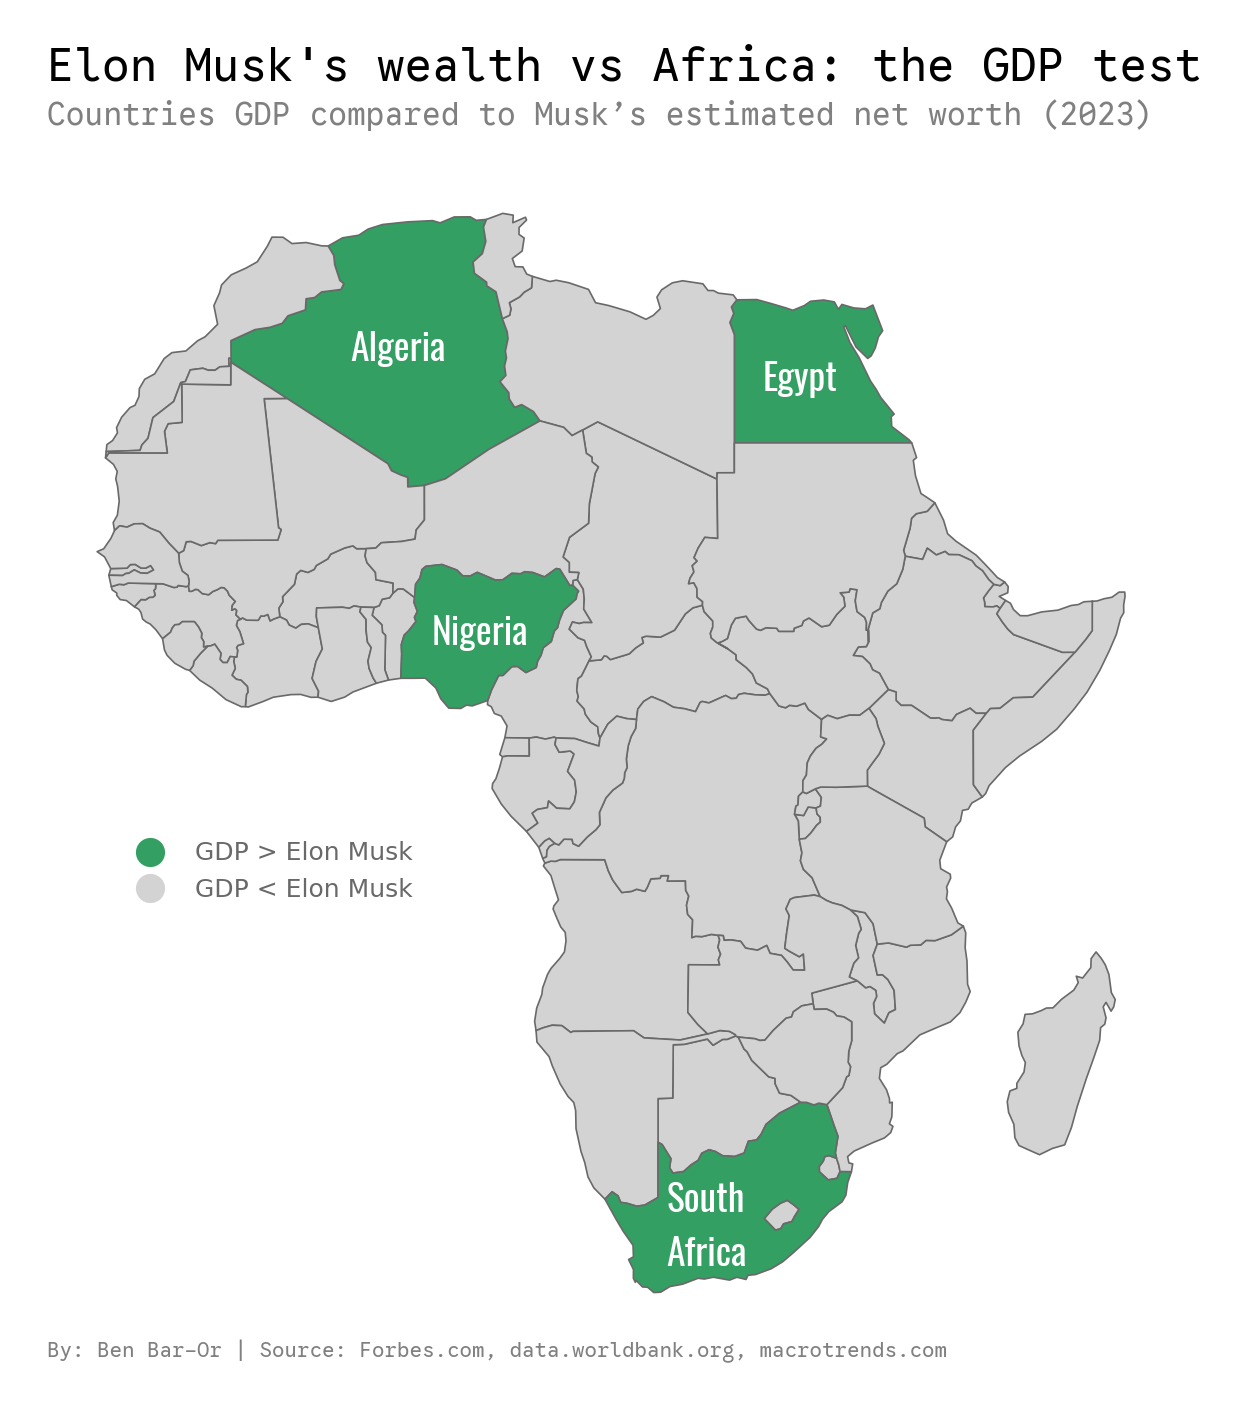

In [19]:
fig, ax = plt.subplots(dpi = 300, layout = 'tight')

africa = world.loc[world['continent'] == 'Africa']

fonts = {'title': load_google_font('Google Sans Code'),
        "labels": load_google_font('Oswald'),
        "footer": load_google_font('Merriweather')}

color_mapping = {
  True: "lightgrey",
  False: "#339f62"
}

africa.plot(color=africa['is_smaller_than_elon'].map(color_mapping), ax=ax, 
            edgecolor = 'dimgrey', linewidth = 0.4)


ax_text(x= -21, y = 48.5, s = "Elon Musk's wealth vs Africa: the GDP test",            # TITLE
       font = fonts['title'], fontsize = 11)

ax_text(x= -21, y = 45, s = "Countries GDP compared to Musk’s estimated net worth (2023)",   # SUB TITLE
       font = fonts['title'], fontsize = 7.5, color = 'grey')

ax_text(x= -21, y = -38, s = """By: Ben Bar-Or | Source: Forbes.com, data.worldbank.org, macrotrends.com""",
       font = fonts['title'], fontsize = 5, color = 'grey')                                  # FOOTER


countries_to_label = ["Algeria", "Nigeria", "Egypt", "South\nAfrica"]                        # COUNTRY LABELS
labels = {'color': 'white', 'font': fonts["labels"],
         'fontsize': 9, 'ha': 'center', 'va': 'bottom'}
ax_text(x=2.5, y=27, s = countries_to_label[0], **labels)
ax_text(x=29.4, y=25, s = countries_to_label[2], **labels)
ax_text(x=8, y=8 , s = countries_to_label[1], **labels)
ax_text(x=23.15, y=-33.5 , s = countries_to_label[3], **labels)

ax.axis('off')

dot_true = Line2D([0], [0], marker='o', color='w', label="GDP > Elon Musk",                   # LEGEND
                  markerfacecolor='#339f62', markersize=8)
dot_false = Line2D([0], [0], marker='o', color='w', label="GDP < Elon Musk",
                   markerfacecolor='lightgrey', markersize=8)
ax.legend(handles=[dot_true, dot_false],
         loc = 'center left', bbox_to_anchor=(0.05, 0.4),
         fontsize = 6, labelcolor = 'dimgrey', edgecolor = 'white')

plt.savefig("elon_africa.png", dpi = 300, bbox_inches = 'tight')
plt.show()